In [7]:
import os
import argparse
import cv2
import numpy as np
import nibabel as nib
from glob import glob
from multiprocessing.dummy import Pool


In [8]:
# # !tar -xvf Task02_Heart.tar
import nibabel as nib 
vol = nib.load('/home/vandangorade/ISBI24/DKD/lits/data/train/volume-0.nii').get_fdata()
vol = np.transpose(vol, (2, 0, 1))

seg = nib.load(os.path.join("/home/vandangorade/ISBI24/DKD/lits/data/train/", 'segmentation-0.nii')).get_fdata().astype('int8')
seg = np.transpose(seg, (2, 0, 1))

In [9]:
vol.shape

(75, 512, 512)

In [27]:
# mask_slice = seg[100, ...]
# print(np.any(mask_slice > 0))

(130, 320, 320)

In [103]:
!rm -r ./kits/train/case_00151/

In [9]:
import os
import nibabel as nib

data_dir = '/home/vandangorade/ISBI24/DKD/Lits19/train/case_00001/volume.nii.gz'

# List all case folders in the data directory
case_folders = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]

for case_folder in case_folders:
    # Construct the path to the imaging.nii.gz file in each case folder
    imaging_path = os.path.join(data_dir, case_folder, 'volume.nii.gz')

    try:
        # Load the NIfTI file and get the image data as a NumPy array
        img = nib.load(imaging_path).get_fdata()
        
        # Check the shape of the loaded image data to ensure it's valid
        if img.shape[0] > 0:
            print(f"Case '{case_folder}': volume.nii.gz is loaded successfully.")
        else:
            print(f"Case '{case_folder}': volume.nii.gz appears to have invalid data.")
    
    except Exception as e:
        print(f"Case '{case_folder}': Error loading Imaging.nii.gz - {e}")



Case 'case_00001': Error loading Imaging.nii.gz - File /home/vandangorade/ISBI24/DKD/Lits19/train/case_00001/volume.nii.gz is not a gzip file
Case 'case_00005': Error loading Imaging.nii.gz - File /home/vandangorade/ISBI24/DKD/Lits19/train/case_00005/volume.nii.gz is not a gzip file
Case 'case_00007': Error loading Imaging.nii.gz - File /home/vandangorade/ISBI24/DKD/Lits19/train/case_00007/volume.nii.gz is not a gzip file
Case 'case_00008': Error loading Imaging.nii.gz - File /home/vandangorade/ISBI24/DKD/Lits19/train/case_00008/volume.nii.gz is not a gzip file
Case 'case_00009': Error loading Imaging.nii.gz - File /home/vandangorade/ISBI24/DKD/Lits19/train/case_00009/volume.nii.gz is not a gzip file
Case 'case_00011': Error loading Imaging.nii.gz - File /home/vandangorade/ISBI24/DKD/Lits19/train/case_00011/volume.nii.gz is not a gzip file
Case 'case_00012': Error loading Imaging.nii.gz - File /home/vandangorade/ISBI24/DKD/Lits19/train/case_00012/volume.nii.gz is not a gzip file
Case '

In [18]:
import os
import argparse
import cv2
import numpy as np
import nibabel as nib
from glob import glob
from multiprocessing.dummy import Pool

class Args:
    def __init__(self):
        self.in_path = "/home/vandangorade/ISBI24/DKD/lits19/test/"#'./kits19/data/'
        self.out_path = '/home/vandangorade/ISBI24/DKD/code/data/lits19/test/'
        self.process_num = 8
        self.dataset = "lits"
        self.task  = "tumor" # organ
        self.mode = "test"

args = Args()


def main():
    if not os.path.exists(args.out_path):
        os.mkdir(args.out_path)
    list_path = os.path.join(args.out_path, args.mode)
    if not os.path.exists(list_path):
        os.mkdir(list_path)

    if args.dataset == 'kits':
        paths = glob(os.path.join(args.in_path, "case_*/imaging*.nii.gz"))
    elif args.dataset == 'lits':
        paths = glob(os.path.join(args.in_path, "case_*/volume*.nii"))
    elif args.dataset == 'heart':
        paths = glob(os.path.join(args.in_path, "case_*/imaging*.nii.gz"))
    

    pool = Pool(args.process_num)
    result = pool.map(make_slice, paths)

    # Save info
    tumor_slices = []
    for i in result:
        tumor_slices += i
    np.save(os.path.join(list_path, '%s_%s_slices.npy' % (args.dataset, args.task)), tumor_slices)


def make_slice(path):
    """
    Cut 3D kits data into 2D slices
    :param path: /*/*.nii.gz
    :return: Slices and Infos
    """
    if args.dataset == 'kits':
        case, vol, seg = read_kits(path)
    elif args.dataset == 'lits':
        case, vol, seg = read_lits(path)
    elif args.dataset == 'heart':
        case, vol, seg = read_heart(path)
        
    result = []
    for i in range(vol.shape[0]):
        ct_slice = vol[i, ...]
        if ct_slice.shape != [512, 512]:
            ct_slice = cv2.resize(ct_slice, dsize=(512, 512), interpolation=cv2.INTER_LINEAR)
        mask_slice = seg[i, ...]
        np.savez_compressed(f'{args.out_path}/{args.mode}/{case}_{i}.npz', ct=ct_slice, mask=mask_slice)
        if args.task == 'organ':
            if np.any(mask_slice > 0):
                result.append(f'{case}_{i}.npz')
        elif args.task == 'tumor':
            if np.any(mask_slice > 1):
                result.append(f'{case}_{i}.npz')

    print(f'complete making slices of {case}')
    return result


def read_kits(path):
    dir = os.path.dirname(path)
    vol = nib.load(path).get_fdata()
    seg = nib.load(os.path.join(dir, 'segmentation.nii.gz')).get_fdata().astype('int8')
    case = os.path.split(dir)[-1][-5:]
    return case, vol, seg


def read_lits(path):
    dir = os.path.dirname(path)
    vol = nib.load(path).get_fdata()
    seg = nib.load(os.path.join(dir, 'segmentation.nii')).get_fdata().astype('int8')
    vol = np.transpose(vol, (2, 0, 1))
    seg = np.transpose(seg, (2, 0, 1))
    case = os.path.split(dir)[-1][-5:]
    return case, vol, seg
def read_heart(path):
    dir = os.path.dirname(path)
    vol = nib.load(path).get_fdata()
    seg = nib.load(os.path.join(dir, 'segmentation.nii.gz')).get_fdata().astype('int8')
    vol = np.transpose(vol, (2, 0, 1))
    seg = np.transpose(seg, (2, 0, 1))
    case = os.path.split(dir)[-1][-5:]
    return case, vol, seg


if __name__ == '__main__':
    main()

complete making slices of 00055
complete making slices of 00055
complete making slices of 00129
complete making slices of 00012
complete making slices of 00011
complete making slices of 00129
complete making slices of 00012
complete making slices of 00011
complete making slices of 00018
complete making slices of 00110
complete making slices of 00113
complete making slices of 00024
complete making slices of 00017
complete making slices of 00060
complete making slices of 00075
complete making slices of 00066
complete making slices of 00018
complete making slices of 00085
complete making slices of 00110
complete making slices of 00024
complete making slices of 00113
complete making slices of 00017
complete making slices of 00046
complete making slices of 00060
complete making slices of 00053
complete making slices of 00056
complete making slices of 00082
complete making slices of 00054
complete making slices of 00066
complete making slices of 00075
complete making slices of 00124
complete

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Load the NPZ file
data = np.load('/home/vandangorade/ISBI24/DKD/code/data/kits19/test/test/00001_188.npz', allow_pickle=True)

# Get the list of keys in the loaded NPZ file
keys = list(data.keys())

# Print the keys to see what's inside
print("Keys in the NPZ file:", keys)


Keys in the NPZ file: ['ct', 'mask']


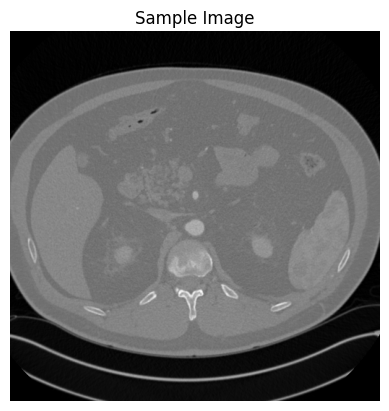

In [84]:
# Access the image data
image_data = data['ct']

# Visualize the image
plt.imshow(image_data, cmap='gray')
plt.title('Sample Image')
plt.axis('off')
plt.show()

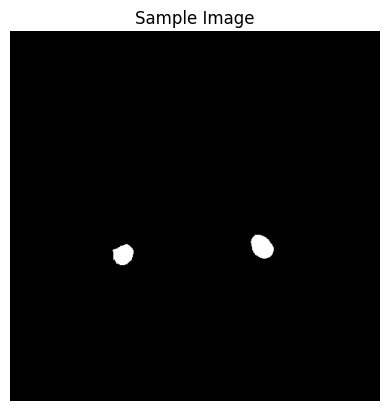

In [85]:
# Access the image data
image_data = data['mask']

# Visualize the image
plt.imshow(image_data, cmap='gray')
plt.title('Sample Image')
plt.axis('off')
plt.show()

In [67]:
!tree

/bin/bash: tree: command not found


In [10]:

import os
import random
import shutil

# Set the paths for the data and test directories
# Set the paths for the data and test directories
data_dir = '/home/vandangorade/ISBI24/DKD/lits19/data'
test_dir = './lits19/test/'

# Ensure the test directory exists, create it if not
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# List all case folders in the data directory
case_folders = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]

# Randomly select 42 case folders (or adjust the number as needed)
selected_cases = random.sample(case_folders, 70)

# Move the selected case folders to the test directory
for case in selected_cases:
    src_path = os.path.join(data_dir, case)
    dest_path = os.path.join(test_dir, case)
    
    # Use shutil.move to move the folders
    shutil.move(src_path, dest_path)
    print(f"Moved '{case}' to the 'test' directory.")

print("Done!")


Moved 'case_00017' to the 'test' directory.
Moved 'case_00056' to the 'test' directory.
Moved 'case_00092' to the 'test' directory.
Moved 'case_00110' to the 'test' directory.
Moved 'case_00126' to the 'test' directory.
Moved 'case_00078' to the 'test' directory.
Moved 'case_00012' to the 'test' directory.
Moved 'case_00060' to the 'test' directory.
Moved 'case_00075' to the 'test' directory.
Moved 'case_00129' to the 'test' directory.
Moved 'case_00024' to the 'test' directory.
Moved 'case_00066' to the 'test' directory.
Moved 'case_00018' to the 'test' directory.
Moved 'case_00124' to the 'test' directory.
Moved 'case_00104' to the 'test' directory.
Moved 'case_00011' to the 'test' directory.
Moved 'case_00082' to the 'test' directory.
Moved 'case_00008' to the 'test' directory.
Moved 'case_00113' to the 'test' directory.
Moved 'case_00101' to the 'test' directory.
Moved 'case_00130' to the 'test' directory.
Moved 'case_00055' to the 'test' directory.
Moved 'case_00085' to the 'test'

In [2]:
70-42

28